In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
#dataset load
malgenome_all = pd.read_csv('malgenome215dataset1260malware2539benign.csv', 
                         usecols= [*range(0, 5),6,*range(8, 11),12,14,*range(17, 20),
                                  21,22,24,*range(26,33),35,37,40,41,45,46,50,52,54,
                                  57,60,65,69,*range(73,76),85,90,94,97,98,101,104,
                                  110,114,120,131,138,140,146,155,156,161,165,166,
                                  168,172,176,186,188,193,194,198,201,206,215])

In [3]:
malgenome_all.head()

,transact,bindService,onServiceConnected,ServiceConnection,android.os.Binder,attachInterface,TelephonyManager.getSubscriberId,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,Ljava.lang.Class.getField,...,Process.start,IRemoteService,TelephonyManager.getCallState,Runtime.getRuntime,TelephonyManager.isNetworkRoaming,TelephonyManager.getSimOperator,sendMultipartTextMessage,Ljavax.crypto.Cipher,Ljava.lang.Object.getClass,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1,S
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,1,S
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,S
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,S
4,1,1,1,1,1,1,1,1,0,0,...,0,0,0,1,0,0,0,0,1,S


In [4]:
#drebin_all.info()
X = malgenome_all.iloc[0:,0:69]  #independent columns
y = malgenome_all.iloc[0:,-1]
X["TelephonyManager.getSimCountryIso"] = pd.to_numeric(X['TelephonyManager.getSimCountryIso'], errors='coerce').fillna(0).astype(int)

In [5]:
y = y.map(dict(S=1, B=0))

In [6]:
y[1]

1

In [7]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size = 0.5, random_state = 0)


In [8]:
#mandatory import 
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA


from sklearn.feature_selection import RFE

In [9]:
pre = []
rec = []
fs = []
acc = []
auc = []
def clear_metrics(): 
    pre.clear()
    rec.clear()
    fs.clear()
    acc.clear()
    auc.clear()

In [10]:
import csv
def results_to_csv(title):
    with open(title+ '.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['Accuracy','Precision', 'Recall', 'F1','AUC'])
        writer.writerows(zip(acc, pre, rec, fs, auc))
        
def allscore(scores,i):
    acc.insert(i,scores['test_accuracy'].mean())
    fs.insert(i,scores['test_f1'].mean())
    pre.insert(i,scores['test_precision'].mean())
    rec.insert(i,scores['test_recall'].mean())
    auc.insert(i,scores['test_roc_auc'].mean())
    print("Accuracy: %0.4f   (+/- %0.4f)" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2))
    print("Precision: %0.4f   (+/- %0.4f)" % (scores['test_precision'].mean(), scores['test_accuracy'].std() * 2))
    print("Recall: %0.4f   (+/- %0.4f)" % (scores['test_recall'].mean(), scores['test_accuracy'].std() * 2))
    print("F-1 Score: %0.4f   (+/- %0.4f)" % (scores['test_f1'].mean(), scores['test_accuracy'].std() * 2))
    print("ROC-AUC: %0.4f   (+/- %0.4f)" % (scores['test_roc_auc'].mean(), scores['test_accuracy'].std() * 2))
def run_randomForest(X,y, i=0):
    scoring = ['precision', 'recall', 'f1','accuracy','roc_auc']
    clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    scores = cross_validate(clf, X, y, cv=10, n_jobs=-1,
                        scoring=scoring, return_train_score=False)
    print('Classification Report for Random Forest:   ', i)
    allscore(scores,i)
def incremental_plot(i,j,title, x_axis = "Number of Features"): 
    from pylab import rcParams
    %matplotlib inline 
    rcParams['figure.figsize'] = 10,8
    sns.set_style('whitegrid')
    x = range(i,j)
    y1 = pre
    y2 = rec
    y3 = acc
    y4 = fs

    fig = plt.figure()
    ax = plt.subplot(111)
    #savefig('f.png', bbox_inches='tight')
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel("Performance Metrics")
    ax.plot(x,y1, mew = 1, label='Precision') #mew = marker width
    ax.plot(x,y2,  mew = 1, label='Recall') #mew = marker width
    ax.plot(x,y3,  mew = 1, label='Accuracy') #mew = marker width
    ax.plot(x,y4, mew = 1, label='F-1 Score') #mew = marker width
    ax.legend(loc='upper center', bbox_to_anchor=(1.12, 0.6), shadow=True, prop={'size': 15}, ncol=1)
    #plt.plot(x1,y1, marker = '+', mew = 10)
    plt.savefig(title + '.png', bbox_inches='tight', pad_inches=.1)
def incremental_plot_auc(i,j,title, x_axis = "Number of Features"): 
    from pylab import rcParams
    %matplotlib inline 
    rcParams['figure.figsize'] = 10,8
    sns.set_style('whitegrid')
    x = range(i,j)
    y1 = auc
 

    fig = plt.figure()
    ax = plt.subplot(111)
    #savefig('f.png', bbox_inches='tight')
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel("ROC-AUC Score")
    ax.plot(x,y1, mew = 1, label='ROC-AUC') #mew = marker width
    ax.legend(loc='upper center', bbox_to_anchor=(1.12, 0.6), shadow=True, prop={'size': 15}, ncol=1)
    #plt.plot(x1,y1, marker = '+', mew = 10)
    plt.savefig(title + '_AUC.png', bbox_inches='tight', pad_inches=.1)
    
    

In [11]:
def get_correlation(data, threshold):
    corr_col = set()
    corrmat = data.corr()
    for i in range(len(corrmat.columns)):
        for j in range(i):
            if abs(corrmat.iloc[i, j])> threshold:
                colname = corrmat.columns[i]
                corr_col.add(colname)
    return corr_col
def grouped_correlated(X):
    corr_features = get_correlation(X, 0.85)
    X_uncorrelated = X.drop(labels = corr_features, axis =1)
    corrmat = X.corr()
    corrdata = corrmat.abs().stack()
    corrdata = corrdata.sort_values(ascending=False)
    corrdata = corrdata[corrdata>0.85]
    corrdata = corrdata[corrdata<1]
    corrdata = pd.DataFrame(corrdata).reset_index()
    corrdata.columns = ['features1', 'features2', 'corr_value']
    #corrdata
    grouped_feature_list = []
    correlated_groups_list = []
    for feature in corrdata.features1.unique():
        if feature not in grouped_feature_list:
            correlated_block = corrdata[corrdata.features1 == feature]
            grouped_feature_list = grouped_feature_list + list(correlated_block.features2.unique()) + [feature]
            correlated_groups_list.append(correlated_block)
    #Feature Importance based on tree based classifiers 

    important_features = []
    for group in correlated_groups_list:
        features = list(group.features1.unique()) + list(group.features2.unique())
        rf = RandomForestClassifier(n_estimators=100,n_jobs=-1, random_state=0)
        rf.fit(X[features], y)

        importance = pd.concat([pd.Series(features), pd.Series(rf.feature_importances_)], axis = 1)
        importance.columns = ['features', 'importance']
        importance.sort_values(by = 'importance', ascending = False, inplace = True)
        feat = importance.iloc[0]
        important_features.append(feat)
    important_features= pd.DataFrame(important_features)
    important_features.reset_index(inplace=True, drop = True)
    important_features
    features_to_consider = set(important_features['features'])
    features_to_discard = set(corr_features) - set(features_to_consider)
    features_to_discard = list(features_to_discard)
    X_grouped_correlated = X.drop(labels = features_to_discard, axis = 1)
    print (X_grouped_correlated.shape)
    return X_grouped_correlated
def to_dataframe(X):
    print(X.shape)
    X_return = pd.DataFrame(data=X,
          index=np.arange(1, X.shape[0]+1), columns=np.arange(1, X.shape[1]+1))
    
    return X_return

## Feature Importance using SelectKBest, chi2, f-score

In [13]:
#apply SelectKBest class to extract top 10 best features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X_train,y_train)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['APIs','Score']  #naming the dataframe columns

In [14]:
clear_metrics()
#X_top_feat_imps
for index in range(1,70,1):
    top_api_indexes = []
    top_api_indexes = featureScores.Score.nlargest(index).index
    X_top_feat_imps = X_validate.iloc[0:,top_api_indexes]
    print(X_top_feat_imps.shape)
    run_randomForest(X_top_feat_imps,y_validate, index)

(1900, 1)
Classification Report for Random Forest:    1
Accuracy: 0.7989   (+/- 0.0533)
Precision: 0.7390   (+/- 0.0533)
Recall: 0.6631   (+/- 0.0533)
F-1 Score: 0.6976   (+/- 0.0533)
ROC-AUC: 0.7675   (+/- 0.0533)
(1900, 2)
Classification Report for Random Forest:    2
Accuracy: 0.8563   (+/- 0.0407)
Precision: 0.9386   (+/- 0.0407)
Recall: 0.6315   (+/- 0.0407)
F-1 Score: 0.7532   (+/- 0.0407)
ROC-AUC: 0.9060   (+/- 0.0407)
(1900, 3)
Classification Report for Random Forest:    3
Accuracy: 0.8563   (+/- 0.0411)
Precision: 0.9308   (+/- 0.0411)
Recall: 0.6375   (+/- 0.0411)
F-1 Score: 0.7552   (+/- 0.0411)
ROC-AUC: 0.9172   (+/- 0.0411)
(1900, 4)
Classification Report for Random Forest:    4
Accuracy: 0.8552   (+/- 0.0425)
Precision: 0.9287   (+/- 0.0425)
Recall: 0.6360   (+/- 0.0425)
F-1 Score: 0.7534   (+/- 0.0425)
ROC-AUC: 0.9170   (+/- 0.0425)
(1900, 5)
Classification Report for Random Forest:    5
Accuracy: 0.8563   (+/- 0.0449)
Precision: 0.9343   (+/- 0.0449)
Recall: 0.6345   (+

Classification Report for Random Forest:    39
Accuracy: 0.9763   (+/- 0.0249)
Precision: 0.9747   (+/- 0.0249)
Recall: 0.9579   (+/- 0.0249)
F-1 Score: 0.9656   (+/- 0.0249)
ROC-AUC: 0.9942   (+/- 0.0249)
(1900, 40)
Classification Report for Random Forest:    40
Accuracy: 0.9779   (+/- 0.0181)
Precision: 0.9706   (+/- 0.0181)
Recall: 0.9669   (+/- 0.0181)
F-1 Score: 0.9683   (+/- 0.0181)
ROC-AUC: 0.9942   (+/- 0.0181)
(1900, 41)
Classification Report for Random Forest:    41
Accuracy: 0.9769   (+/- 0.0200)
Precision: 0.9732   (+/- 0.0200)
Recall: 0.9609   (+/- 0.0200)
F-1 Score: 0.9666   (+/- 0.0200)
ROC-AUC: 0.9937   (+/- 0.0200)
(1900, 42)
Classification Report for Random Forest:    42
Accuracy: 0.9774   (+/- 0.0240)
Precision: 0.9748   (+/- 0.0240)
Recall: 0.9609   (+/- 0.0240)
F-1 Score: 0.9674   (+/- 0.0240)
ROC-AUC: 0.9959   (+/- 0.0240)
(1900, 43)
Classification Report for Random Forest:    43
Accuracy: 0.9784   (+/- 0.0233)
Precision: 0.9750   (+/- 0.0233)
Recall: 0.9639   (+/

In [15]:
title = "Feature Selection using SelectKBest(Chi-Square Test)"
results_to_csv(title)

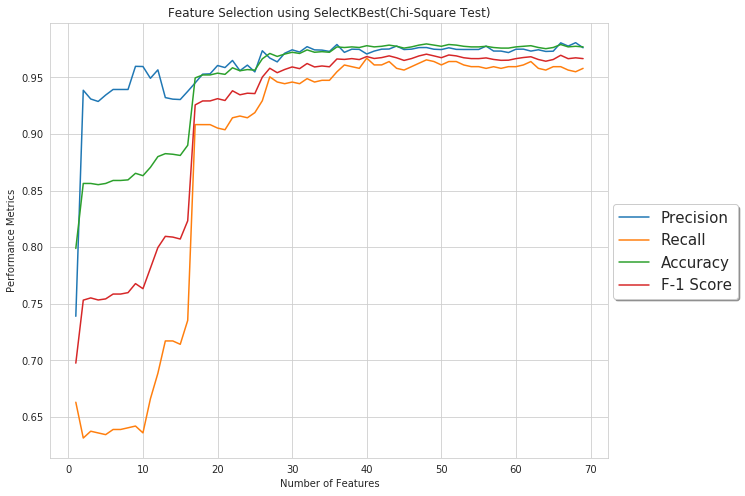

In [16]:
incremental_plot(1,70,title)

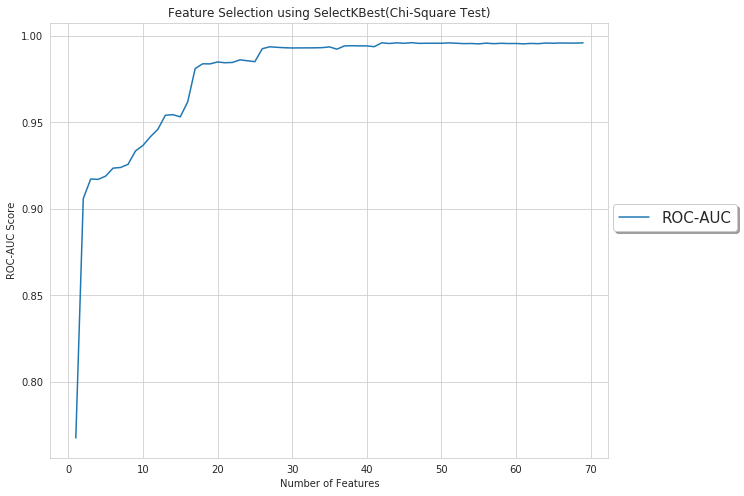

In [17]:
incremental_plot_auc(1,70,title)

In [18]:
#apply SelectKBest class to extract top 10 best features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X_train,y_train)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['APIs','Score']  #naming the dataframe columns

In [19]:
featureScores.Score.nlargest(5).index

Int64Index([6, 4, 3, 2, 1], dtype='int64')

In [20]:
clear_metrics()
#X_top_feat_imps
for index in range(1,70,1):
    top_api_indexes = []
    top_api_indexes = featureScores.Score.nlargest(index).index
    X_top_feat_imps = X_validate.iloc[0:,top_api_indexes]
    print(X_top_feat_imps.shape)
    run_randomForest(X_top_feat_imps,y_validate, index)

(1900, 1)
Classification Report for Random Forest:    1
Accuracy: 0.7989   (+/- 0.0533)
Precision: 0.7390   (+/- 0.0533)
Recall: 0.6631   (+/- 0.0533)
F-1 Score: 0.6976   (+/- 0.0533)
ROC-AUC: 0.7675   (+/- 0.0533)
(1900, 2)
Classification Report for Random Forest:    2
Accuracy: 0.8531   (+/- 0.0433)
Precision: 0.9500   (+/- 0.0433)
Recall: 0.6135   (+/- 0.0433)
F-1 Score: 0.7434   (+/- 0.0433)
ROC-AUC: 0.8992   (+/- 0.0433)
(1900, 3)
Classification Report for Random Forest:    3
Accuracy: 0.8542   (+/- 0.0407)
Precision: 0.9442   (+/- 0.0407)
Recall: 0.6210   (+/- 0.0407)
F-1 Score: 0.7473   (+/- 0.0407)
ROC-AUC: 0.9117   (+/- 0.0407)
(1900, 4)
Classification Report for Random Forest:    4
Accuracy: 0.8563   (+/- 0.0433)
Precision: 0.9501   (+/- 0.0433)
Recall: 0.6225   (+/- 0.0433)
F-1 Score: 0.7505   (+/- 0.0433)
ROC-AUC: 0.9135   (+/- 0.0433)
(1900, 5)
Classification Report for Random Forest:    5
Accuracy: 0.8552   (+/- 0.0443)
Precision: 0.9477   (+/- 0.0443)
Recall: 0.6210   (+

Classification Report for Random Forest:    39
Accuracy: 0.9779   (+/- 0.0205)
Precision: 0.9748   (+/- 0.0205)
Recall: 0.9624   (+/- 0.0205)
F-1 Score: 0.9680   (+/- 0.0205)
ROC-AUC: 0.9938   (+/- 0.0205)
(1900, 40)
Classification Report for Random Forest:    40
Accuracy: 0.9779   (+/- 0.0244)
Precision: 0.9749   (+/- 0.0244)
Recall: 0.9624   (+/- 0.0244)
F-1 Score: 0.9681   (+/- 0.0244)
ROC-AUC: 0.9941   (+/- 0.0244)
(1900, 41)
Classification Report for Random Forest:    41
Accuracy: 0.9784   (+/- 0.0224)
Precision: 0.9747   (+/- 0.0224)
Recall: 0.9639   (+/- 0.0224)
F-1 Score: 0.9689   (+/- 0.0224)
ROC-AUC: 0.9939   (+/- 0.0224)
(1900, 42)
Classification Report for Random Forest:    42
Accuracy: 0.9732   (+/- 0.0251)
Precision: 0.9672   (+/- 0.0251)
Recall: 0.9564   (+/- 0.0251)
F-1 Score: 0.9613   (+/- 0.0251)
ROC-AUC: 0.9939   (+/- 0.0251)
(1900, 43)
Classification Report for Random Forest:    43
Accuracy: 0.9763   (+/- 0.0212)
Precision: 0.9746   (+/- 0.0212)
Recall: 0.9579   (+/

In [21]:
title = "Feature Selection using SelectKBest(ANOVA F-value)"
results_to_csv(title)

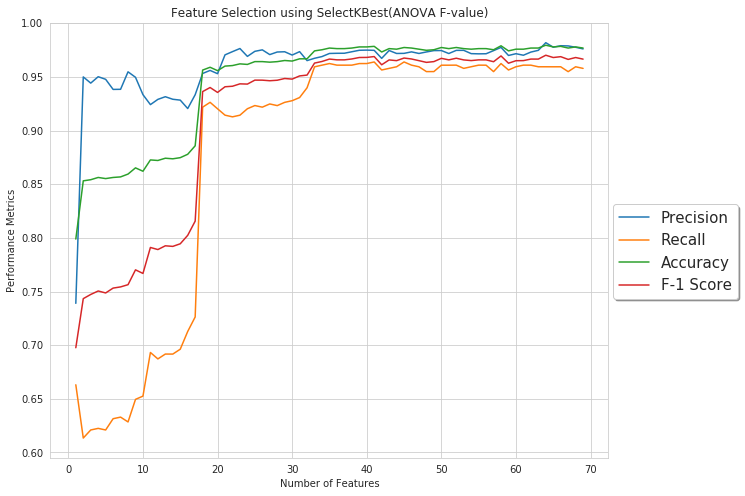

In [22]:
incremental_plot(1,70,title)

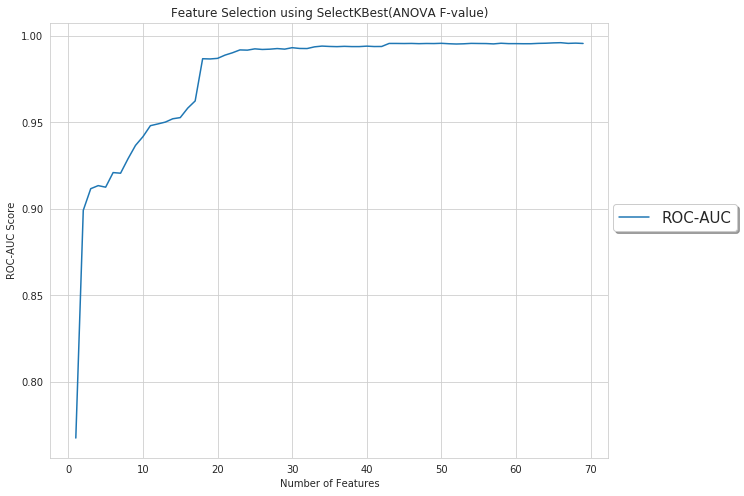

In [23]:
incremental_plot_auc(1,70,title)

In [24]:
X_top_feat_imps.shape

(1900, 69)

## Feature Importance (feature_importances_)

In [25]:
#RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
model.fit(X_train,y_train)
feat_importances = pd.Series(model.feature_importances_, index=X_validate.columns)

In [26]:
clear_metrics()
#X_top_feat_imps
for index in range(1,70,1):
    top_api_indexes = []
    top_api_indexes = feat_importances.nlargest(index).index
    X_top_feat_imps = X_validate.loc[:,top_api_indexes]
    print(X_top_feat_imps.shape)
    run_randomForest(X_top_feat_imps,y_validate, index)

(1900, 1)
Classification Report for Random Forest:    1
Accuracy: 0.7989   (+/- 0.0533)
Precision: 0.7390   (+/- 0.0533)
Recall: 0.6631   (+/- 0.0533)
F-1 Score: 0.6976   (+/- 0.0533)
ROC-AUC: 0.7675   (+/- 0.0533)
(1900, 2)
Classification Report for Random Forest:    2
Accuracy: 0.8531   (+/- 0.0433)
Precision: 0.9500   (+/- 0.0433)
Recall: 0.6135   (+/- 0.0433)
F-1 Score: 0.7434   (+/- 0.0433)
ROC-AUC: 0.8992   (+/- 0.0433)
(1900, 3)
Classification Report for Random Forest:    3
Accuracy: 0.9005   (+/- 0.0329)
Precision: 0.8728   (+/- 0.0329)
Recall: 0.8421   (+/- 0.0329)
F-1 Score: 0.8552   (+/- 0.0329)
ROC-AUC: 0.9359   (+/- 0.0329)
(1900, 4)
Classification Report for Random Forest:    4
Accuracy: 0.9084   (+/- 0.0252)
Precision: 0.8858   (+/- 0.0252)
Recall: 0.8511   (+/- 0.0252)
F-1 Score: 0.8662   (+/- 0.0252)
ROC-AUC: 0.9491   (+/- 0.0252)
(1900, 5)
Classification Report for Random Forest:    5
Accuracy: 0.9216   (+/- 0.0297)
Precision: 0.9209   (+/- 0.0297)
Recall: 0.8511   (+

Classification Report for Random Forest:    39
Accuracy: 0.9758   (+/- 0.0242)
Precision: 0.9734   (+/- 0.0242)
Recall: 0.9579   (+/- 0.0242)
F-1 Score: 0.9649   (+/- 0.0242)
ROC-AUC: 0.9956   (+/- 0.0242)
(1900, 40)
Classification Report for Random Forest:    40
Accuracy: 0.9758   (+/- 0.0232)
Precision: 0.9717   (+/- 0.0232)
Recall: 0.9594   (+/- 0.0232)
F-1 Score: 0.9650   (+/- 0.0232)
ROC-AUC: 0.9955   (+/- 0.0232)
(1900, 41)
Classification Report for Random Forest:    41
Accuracy: 0.9768   (+/- 0.0287)
Precision: 0.9747   (+/- 0.0287)
Recall: 0.9594   (+/- 0.0287)
F-1 Score: 0.9666   (+/- 0.0287)
ROC-AUC: 0.9959   (+/- 0.0287)
(1900, 42)
Classification Report for Random Forest:    42
Accuracy: 0.9758   (+/- 0.0302)
Precision: 0.9748   (+/- 0.0302)
Recall: 0.9564   (+/- 0.0302)
F-1 Score: 0.9650   (+/- 0.0302)
ROC-AUC: 0.9956   (+/- 0.0302)
(1900, 43)
Classification Report for Random Forest:    43
Accuracy: 0.9763   (+/- 0.0275)
Precision: 0.9760   (+/- 0.0275)
Recall: 0.9564   (+/

In [27]:
title = "Feature Selection using Random Forest Classifier - Feature Importances"
results_to_csv(title)

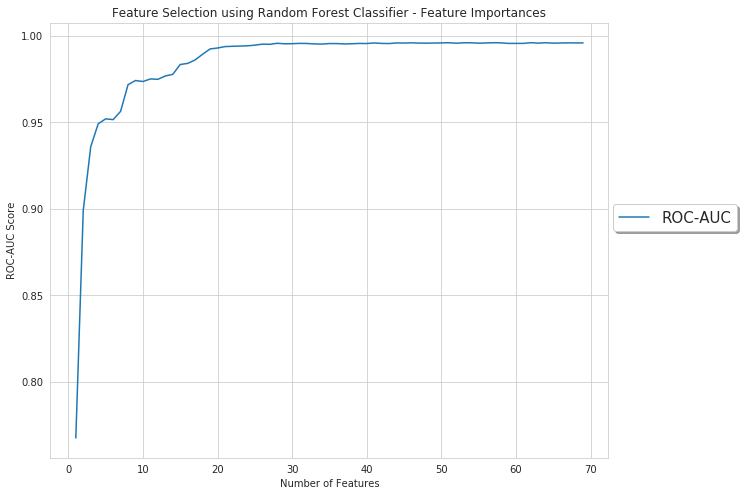

In [28]:
incremental_plot_auc(1,70, title)

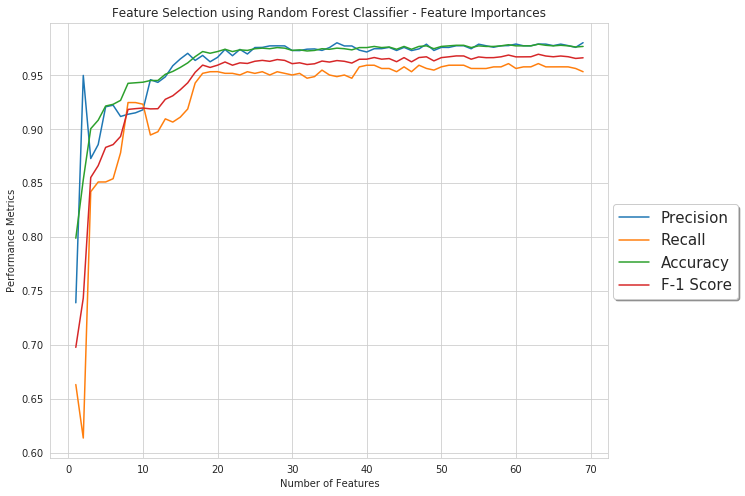

In [29]:
incremental_plot(1,70, title)


In [30]:
#ExtraTreeClassifier
model = ExtraTreesClassifier(n_estimators=100, random_state=0, n_jobs=-1)
model.fit(X_train,y_train)
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)

In [31]:
clear_metrics()
X_top_feat_imps
for index in range(1,70,1):
    top_api_indexes = []
    top_api_indexes = feat_importances.nlargest(index).index
    X_top_feat_imps = X_validate.loc[:,top_api_indexes ]
    print(X_top_feat_imps.shape)
    run_randomForest(X_top_feat_imps,y_validate, index)

(1900, 1)
Classification Report for Random Forest:    1
Accuracy: 0.7989   (+/- 0.0533)
Precision: 0.7390   (+/- 0.0533)
Recall: 0.6631   (+/- 0.0533)
F-1 Score: 0.6976   (+/- 0.0533)
ROC-AUC: 0.7675   (+/- 0.0533)
(1900, 2)
Classification Report for Random Forest:    2
Accuracy: 0.8531   (+/- 0.0433)
Precision: 0.9500   (+/- 0.0433)
Recall: 0.6135   (+/- 0.0433)
F-1 Score: 0.7434   (+/- 0.0433)
ROC-AUC: 0.8992   (+/- 0.0433)
(1900, 3)
Classification Report for Random Forest:    3
Accuracy: 0.9005   (+/- 0.0329)
Precision: 0.8728   (+/- 0.0329)
Recall: 0.8421   (+/- 0.0329)
F-1 Score: 0.8552   (+/- 0.0329)
ROC-AUC: 0.9359   (+/- 0.0329)
(1900, 4)
Classification Report for Random Forest:    4
Accuracy: 0.9079   (+/- 0.0256)
Precision: 0.8833   (+/- 0.0256)
Recall: 0.8526   (+/- 0.0256)
F-1 Score: 0.8659   (+/- 0.0256)
ROC-AUC: 0.9481   (+/- 0.0256)
(1900, 5)
Classification Report for Random Forest:    5
Accuracy: 0.9095   (+/- 0.0291)
Precision: 0.8868   (+/- 0.0291)
Recall: 0.8526   (+

Classification Report for Random Forest:    39
Accuracy: 0.9737   (+/- 0.0253)
Precision: 0.9686   (+/- 0.0253)
Recall: 0.9564   (+/- 0.0253)
F-1 Score: 0.9620   (+/- 0.0253)
ROC-AUC: 0.9959   (+/- 0.0253)
(1900, 40)
Classification Report for Random Forest:    40
Accuracy: 0.9758   (+/- 0.0245)
Precision: 0.9758   (+/- 0.0245)
Recall: 0.9549   (+/- 0.0245)
F-1 Score: 0.9647   (+/- 0.0245)
ROC-AUC: 0.9958   (+/- 0.0245)
(1900, 41)
Classification Report for Random Forest:    41
Accuracy: 0.9769   (+/- 0.0262)
Precision: 0.9746   (+/- 0.0262)
Recall: 0.9594   (+/- 0.0262)
F-1 Score: 0.9665   (+/- 0.0262)
ROC-AUC: 0.9959   (+/- 0.0262)
(1900, 42)
Classification Report for Random Forest:    42
Accuracy: 0.9769   (+/- 0.0245)
Precision: 0.9760   (+/- 0.0245)
Recall: 0.9579   (+/- 0.0245)
F-1 Score: 0.9665   (+/- 0.0245)
ROC-AUC: 0.9957   (+/- 0.0245)
(1900, 43)
Classification Report for Random Forest:    43
Accuracy: 0.9763   (+/- 0.0245)
Precision: 0.9747   (+/- 0.0245)
Recall: 0.9579   (+/

In [32]:
title = "Feature Selection using Extra Trees Classifier Feature - Importances"
results_to_csv(title)

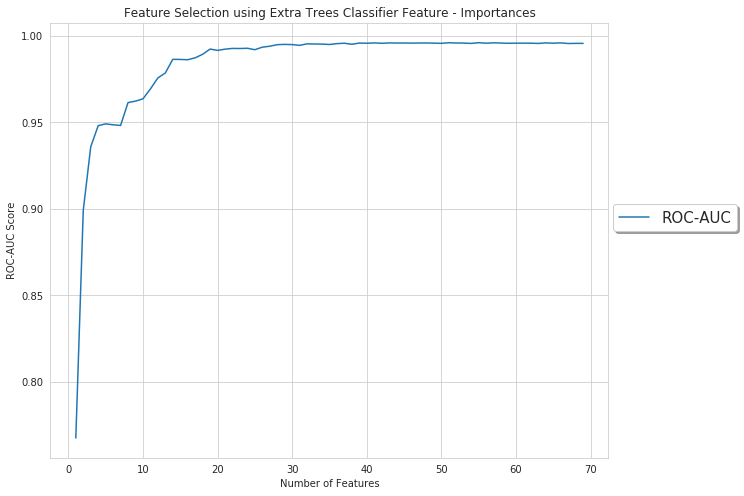

In [33]:
incremental_plot_auc(1,70, title)

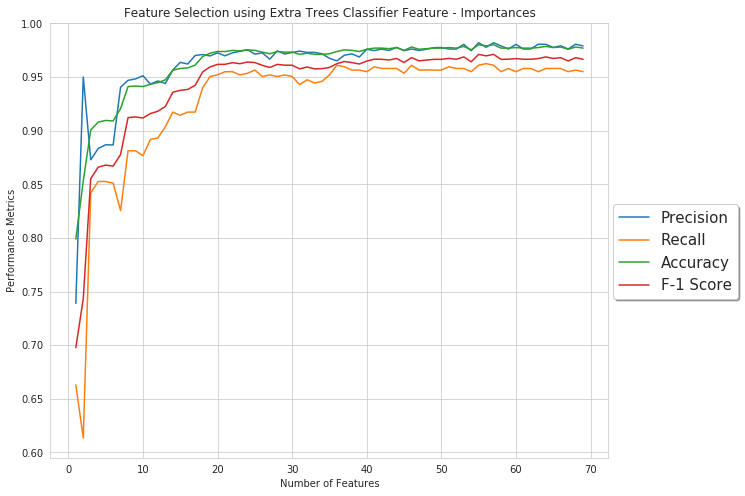

In [34]:
incremental_plot(1,70, title)


## Feature Selection Based on Mutual Information (Entropy) Gain

In [35]:
from sklearn.feature_selection import mutual_info_classif

In [36]:
mi = mutual_info_classif(X_train, y_train)

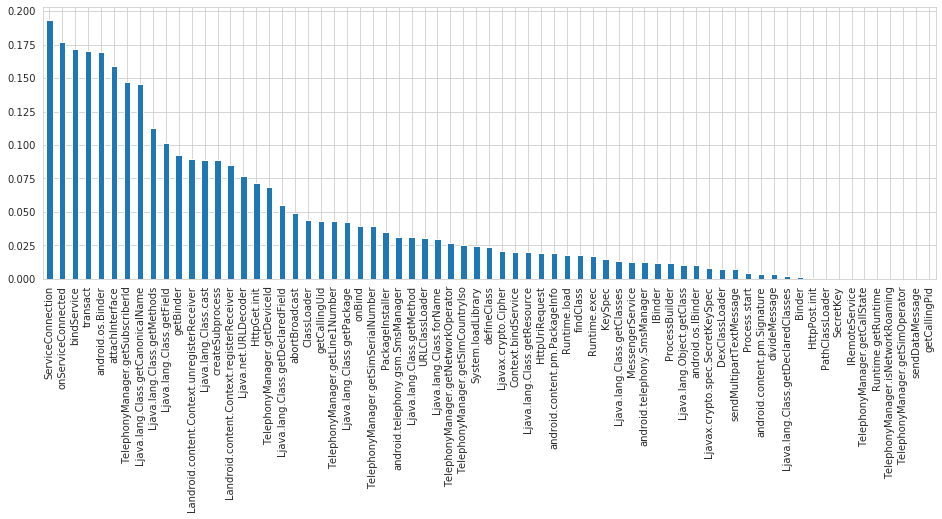

In [37]:
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False, inplace = True)
mi.plot.bar(figsize = (16,5))

In [38]:
clear_metrics()
for index in range(1, 70,1):
    top_api_indexes = []
    top_api_indexes = mi.nlargest(index).index
    X_top_feat_imps = X_validate.loc[:,top_api_indexes ]
    print(X_top_feat_imps.shape)
    run_randomForest(X_top_feat_imps,y_validate, index)

(1900, 1)
Classification Report for Random Forest:    1
Accuracy: 0.7584   (+/- 0.0413)
Precision: 0.6002   (+/- 0.0413)
Recall: 0.9338   (+/- 0.0413)
F-1 Score: 0.7304   (+/- 0.0413)
ROC-AUC: 0.7989   (+/- 0.0413)
(1900, 2)
Classification Report for Random Forest:    2
Accuracy: 0.7621   (+/- 0.0437)
Precision: 0.6043   (+/- 0.0437)
Recall: 0.9338   (+/- 0.0437)
F-1 Score: 0.7335   (+/- 0.0437)
ROC-AUC: 0.8007   (+/- 0.0437)
(1900, 3)
Classification Report for Random Forest:    3
Accuracy: 0.7605   (+/- 0.0442)
Precision: 0.6026   (+/- 0.0442)
Recall: 0.9338   (+/- 0.0442)
F-1 Score: 0.7322   (+/- 0.0442)
ROC-AUC: 0.8009   (+/- 0.0442)
(1900, 4)
Classification Report for Random Forest:    4
Accuracy: 0.7873   (+/- 0.0480)
Precision: 0.6371   (+/- 0.0480)
Recall: 0.9142   (+/- 0.0480)
F-1 Score: 0.7507   (+/- 0.0480)
ROC-AUC: 0.8298   (+/- 0.0480)
(1900, 5)
Classification Report for Random Forest:    5
Accuracy: 0.7926   (+/- 0.0527)
Precision: 0.6473   (+/- 0.0527)
Recall: 0.8977   (+

Classification Report for Random Forest:    39
Accuracy: 0.9684   (+/- 0.0274)
Precision: 0.9725   (+/- 0.0274)
Recall: 0.9368   (+/- 0.0274)
F-1 Score: 0.9537   (+/- 0.0274)
ROC-AUC: 0.9932   (+/- 0.0274)
(1900, 40)
Classification Report for Random Forest:    40
Accuracy: 0.9674   (+/- 0.0248)
Precision: 0.9693   (+/- 0.0248)
Recall: 0.9368   (+/- 0.0248)
F-1 Score: 0.9522   (+/- 0.0248)
ROC-AUC: 0.9935   (+/- 0.0248)
(1900, 41)
Classification Report for Random Forest:    41
Accuracy: 0.9684   (+/- 0.0270)
Precision: 0.9724   (+/- 0.0270)
Recall: 0.9368   (+/- 0.0270)
F-1 Score: 0.9537   (+/- 0.0270)
ROC-AUC: 0.9936   (+/- 0.0270)
(1900, 42)
Classification Report for Random Forest:    42
Accuracy: 0.9684   (+/- 0.0240)
Precision: 0.9710   (+/- 0.0240)
Recall: 0.9383   (+/- 0.0240)
F-1 Score: 0.9538   (+/- 0.0240)
ROC-AUC: 0.9938   (+/- 0.0240)
(1900, 43)
Classification Report for Random Forest:    43
Accuracy: 0.9679   (+/- 0.0246)
Precision: 0.9725   (+/- 0.0246)
Recall: 0.9354   (+/

In [39]:
title = "Feature Selection using Mutual Information Gain (Entropy)"
results_to_csv(title)

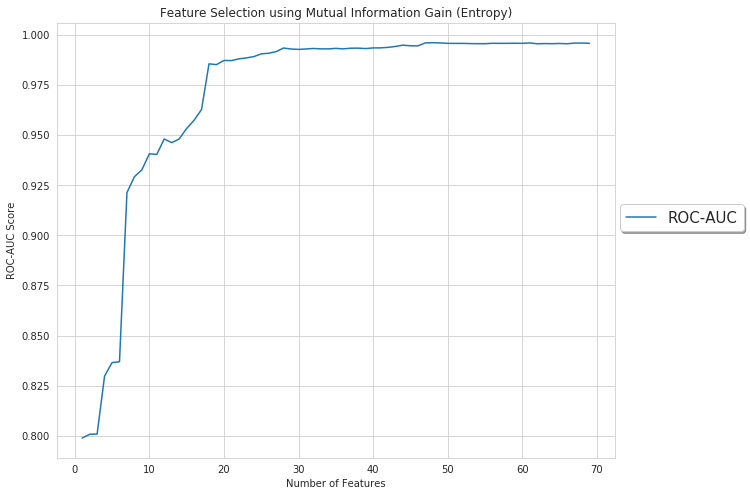

In [40]:
incremental_plot_auc(1,70, title)

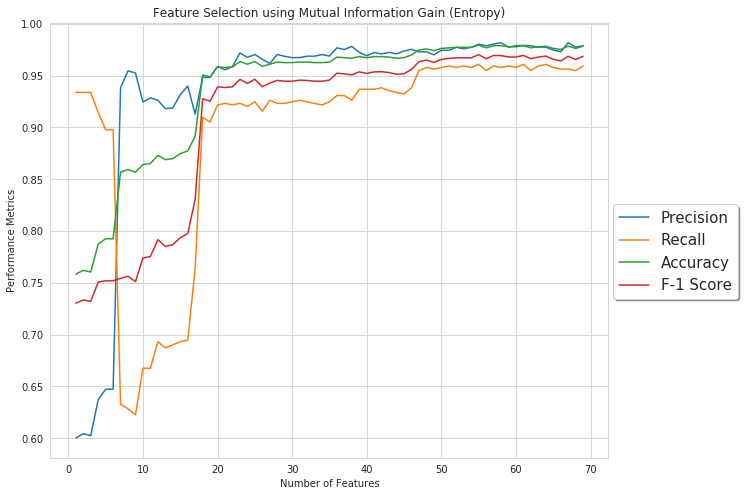

In [41]:
incremental_plot(1,70, title)


In [42]:
top_api_indexes = mi.nlargest(30).index
X_top_feat_imps = X.loc[:,top_api_indexes ]
print(X_top_feat_imps.shape)
run_randomForest(X_top_feat_imps,y, index)

(3799, 30)
Classification Report for Random Forest:    69
Accuracy: 0.9774   (+/- 0.0224)
Precision: 0.9860   (+/- 0.0224)
Recall: 0.9452   (+/- 0.0224)
F-1 Score: 0.9649   (+/- 0.0224)
ROC-AUC: 0.9951   (+/- 0.0224)


## Feature Selection Based on Univariate ROC_AUC for Classification

In [51]:
from sklearn.metrics import roc_auc_score

roc_auc = []
for feature in X_train.columns:
    clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    clf.fit(X_train[feature].to_frame(), y_train)
    y_pred = clf.predict(X_validate[feature].to_frame())
    roc_auc.append(roc_auc_score(y_validate, y_pred))

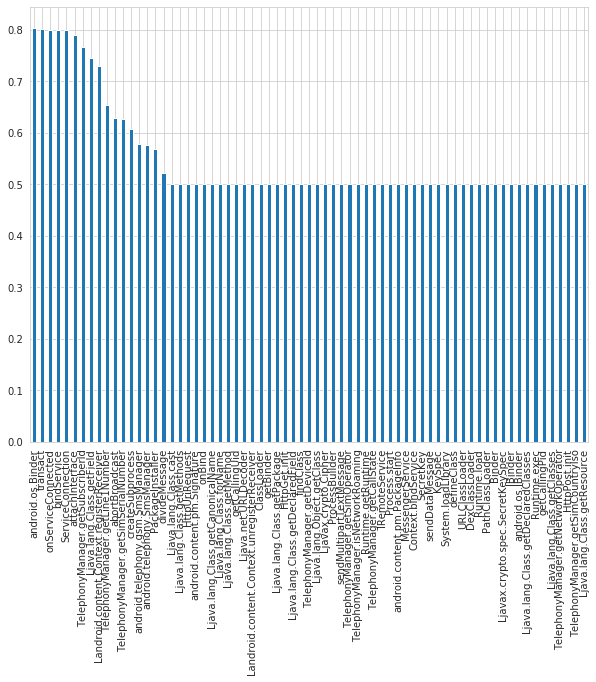

In [52]:
roc_values = pd.Series(roc_auc)
roc_values.index = X_train.columns
roc_values.sort_values(ascending =False, inplace = True)
roc_values.plot.bar()

In [53]:
sel = roc_values[roc_values>0.5]
X_roc_auc = X_train[sel.index]
X_roc_auc.shape

(1899, 17)

In [54]:
clear_metrics()
for index in range(1, len(sel)+1):
    top_api_indexes = []
    top_api_indexes = sel.nlargest(index).index
    X_top_feat_imps = X_validate.loc[:,top_api_indexes ]
    print(X_top_feat_imps.shape)
    run_randomForest(X_top_feat_imps,y_validate, index)

(1900, 1)
Classification Report for Random Forest:    1
Accuracy: 0.7736   (+/- 0.0565)
Precision: 0.6222   (+/- 0.0565)
Recall: 0.9052   (+/- 0.0565)
F-1 Score: 0.7372   (+/- 0.0565)
ROC-AUC: 0.8040   (+/- 0.0565)
(1900, 2)
Classification Report for Random Forest:    2
Accuracy: 0.7742   (+/- 0.0560)
Precision: 0.6228   (+/- 0.0560)
Recall: 0.9052   (+/- 0.0560)
F-1 Score: 0.7376   (+/- 0.0560)
ROC-AUC: 0.8165   (+/- 0.0560)
(1900, 3)
Classification Report for Random Forest:    3
Accuracy: 0.7926   (+/- 0.0521)
Precision: 0.6467   (+/- 0.0521)
Recall: 0.9007   (+/- 0.0521)
F-1 Score: 0.7526   (+/- 0.0521)
ROC-AUC: 0.8359   (+/- 0.0521)
(1900, 4)
Classification Report for Random Forest:    4
Accuracy: 0.7936   (+/- 0.0525)
Precision: 0.6481   (+/- 0.0525)
Recall: 0.9007   (+/- 0.0525)
F-1 Score: 0.7536   (+/- 0.0525)
ROC-AUC: 0.8373   (+/- 0.0525)
(1900, 5)
Classification Report for Random Forest:    5
Accuracy: 0.7926   (+/- 0.0527)
Precision: 0.6473   (+/- 0.0527)
Recall: 0.8977   (+

In [47]:
top_api_indexes = []
top_api_indexes = sel.nlargest(30).index
X_top_feat_imps = X.loc[:,top_api_indexes ]
print(X_top_feat_imps.shape)


(3799, 17)


In [48]:
%%time 
run_randomForest(X_top_feat_imps,y, index)

Classification Report for Random Forest:    17
Accuracy: 0.9637   (+/- 0.0205)
Precision: 0.9518   (+/- 0.0205)
Recall: 0.9381   (+/- 0.0205)
F-1 Score: 0.9446   (+/- 0.0205)
ROC-AUC: 0.9879   (+/- 0.0205)
CPU times: user 50.6 ms, sys: 4.23 ms, total: 54.8 ms
Wall time: 2.68 s


In [55]:
title = "Feature Selection Based on Univariate ROC_AUC Score"
results_to_csv(title)

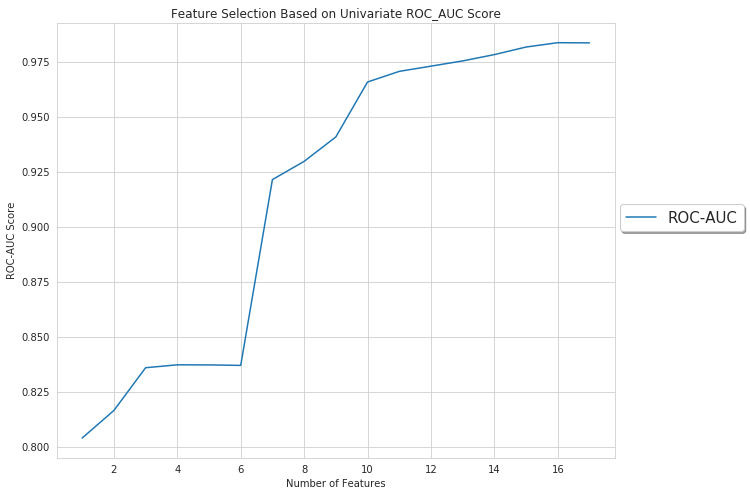

In [56]:
incremental_plot_auc(1,len(sel)+1, title)

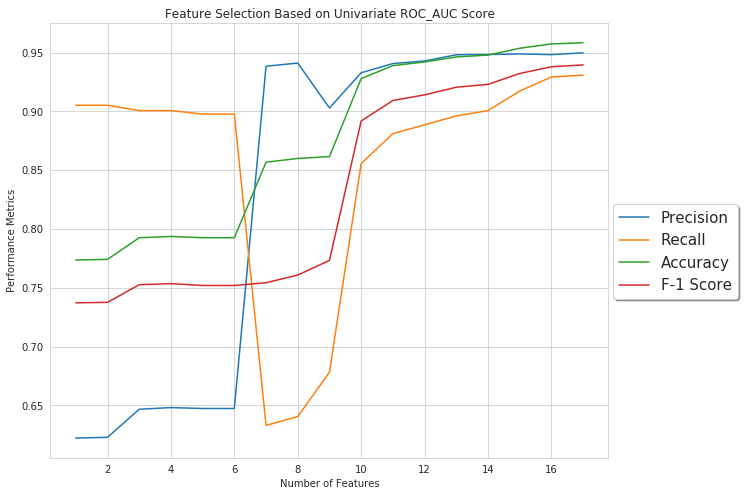

In [57]:
incremental_plot(1,len(sel)+1, title)


## Feature Selection using Principal Component Analysis

In [58]:
clear_metrics()
for component in range(1,70):
    pca = PCA(n_components=component, random_state=0)
    pca.fit(X_train)
    X_pca_optimal = pca.transform(X_validate)
    print('Selected Components: ', component)
    run_randomForest(X_pca_optimal,y_validate,component)
    print()

Selected Components:  1
Classification Report for Random Forest:    1
Accuracy: 0.8773   (+/- 0.0211)
Precision: 0.8181   (+/- 0.0211)
Recall: 0.8375   (+/- 0.0211)
F-1 Score: 0.8270   (+/- 0.0211)
ROC-AUC: 0.9343   (+/- 0.0211)

Selected Components:  2
Classification Report for Random Forest:    2
Accuracy: 0.9374   (+/- 0.0344)
Precision: 0.9148   (+/- 0.0344)
Recall: 0.9068   (+/- 0.0344)
F-1 Score: 0.9104   (+/- 0.0344)
ROC-AUC: 0.9790   (+/- 0.0344)

Selected Components:  3
Classification Report for Random Forest:    3
Accuracy: 0.9621   (+/- 0.0347)
Precision: 0.9604   (+/- 0.0347)
Recall: 0.9308   (+/- 0.0347)
F-1 Score: 0.9451   (+/- 0.0347)
ROC-AUC: 0.9873   (+/- 0.0347)

Selected Components:  4
Classification Report for Random Forest:    4
Accuracy: 0.9674   (+/- 0.0307)
Precision: 0.9663   (+/- 0.0307)
Recall: 0.9399   (+/- 0.0307)
F-1 Score: 0.9527   (+/- 0.0307)
ROC-AUC: 0.9867   (+/- 0.0307)

Selected Components:  5
Classification Report for Random Forest:    5
Accuracy: 

Classification Report for Random Forest:    37
Accuracy: 0.9679   (+/- 0.0291)
Precision: 0.9816   (+/- 0.0291)
Recall: 0.9263   (+/- 0.0291)
F-1 Score: 0.9526   (+/- 0.0291)
ROC-AUC: 0.9921   (+/- 0.0291)

Selected Components:  38
Classification Report for Random Forest:    38
Accuracy: 0.9669   (+/- 0.0300)
Precision: 0.9857   (+/- 0.0300)
Recall: 0.9188   (+/- 0.0300)
F-1 Score: 0.9507   (+/- 0.0300)
ROC-AUC: 0.9926   (+/- 0.0300)

Selected Components:  39
Classification Report for Random Forest:    39
Accuracy: 0.9690   (+/- 0.0337)
Precision: 0.9872   (+/- 0.0337)
Recall: 0.9233   (+/- 0.0337)
F-1 Score: 0.9538   (+/- 0.0337)
ROC-AUC: 0.9916   (+/- 0.0337)

Selected Components:  40
Classification Report for Random Forest:    40
Accuracy: 0.9674   (+/- 0.0228)
Precision: 0.9816   (+/- 0.0228)
Recall: 0.9248   (+/- 0.0228)
F-1 Score: 0.9519   (+/- 0.0228)
ROC-AUC: 0.9929   (+/- 0.0228)

Selected Components:  41
Classification Report for Random Forest:    41
Accuracy: 0.9695   (+/- 0

In [59]:
title = "Feature Selection using Principal Component Analysis"
results_to_csv(title)

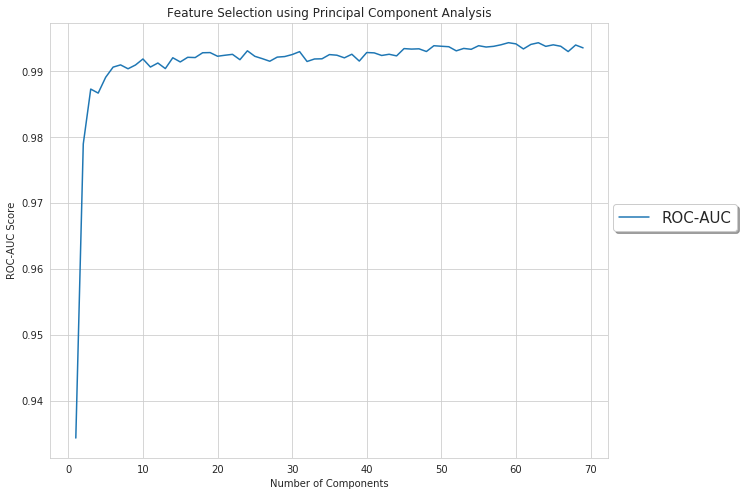

In [60]:
incremental_plot_auc(1,70, title, "Number of Components")

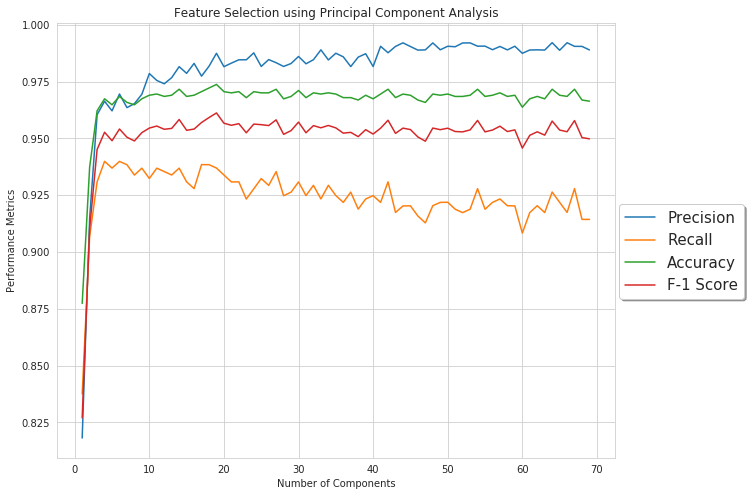

In [61]:
incremental_plot(1,70, title, "Number of Components")


## Feature Selection using RFE (RandomForestClassifier)

In [62]:
#best RFE(RandomForestClassifier) features
clear_metrics()
for index in range(1, 70):
    sel = RFE(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1), n_features_to_select=index)
    sel.fit(X_train, y_train)
    X_transform = sel.transform(X_validate)
    print(X_transform.shape)
    print('Selected Feature: ', index)
    run_randomForest(X_transform, y_validate, index)

(1900, 1)
Selected Feature:  1
Classification Report for Random Forest:    1
Accuracy: 0.7989   (+/- 0.0533)
Precision: 0.7390   (+/- 0.0533)
Recall: 0.6631   (+/- 0.0533)
F-1 Score: 0.6976   (+/- 0.0533)
ROC-AUC: 0.7675   (+/- 0.0533)
(1900, 2)
Selected Feature:  2
Classification Report for Random Forest:    2
Accuracy: 0.8531   (+/- 0.0433)
Precision: 0.9500   (+/- 0.0433)
Recall: 0.6135   (+/- 0.0433)
F-1 Score: 0.7434   (+/- 0.0433)
ROC-AUC: 0.8992   (+/- 0.0433)
(1900, 3)
Selected Feature:  3
Classification Report for Random Forest:    3
Accuracy: 0.8573   (+/- 0.0456)
Precision: 0.9543   (+/- 0.0456)
Recall: 0.6225   (+/- 0.0456)
F-1 Score: 0.7519   (+/- 0.0456)
ROC-AUC: 0.9138   (+/- 0.0456)
(1900, 4)
Selected Feature:  4
Classification Report for Random Forest:    4
Accuracy: 0.9084   (+/- 0.0252)
Precision: 0.8858   (+/- 0.0252)
Recall: 0.8511   (+/- 0.0252)
F-1 Score: 0.8662   (+/- 0.0252)
ROC-AUC: 0.9491   (+/- 0.0252)
(1900, 5)
Selected Feature:  5
Classification Report for

(1900, 36)
Selected Feature:  36
Classification Report for Random Forest:    36
Accuracy: 0.9758   (+/- 0.0283)
Precision: 0.9747   (+/- 0.0283)
Recall: 0.9564   (+/- 0.0283)
F-1 Score: 0.9650   (+/- 0.0283)
ROC-AUC: 0.9960   (+/- 0.0283)
(1900, 37)
Selected Feature:  37
Classification Report for Random Forest:    37
Accuracy: 0.9753   (+/- 0.0299)
Precision: 0.9718   (+/- 0.0299)
Recall: 0.9579   (+/- 0.0299)
F-1 Score: 0.9644   (+/- 0.0299)
ROC-AUC: 0.9960   (+/- 0.0299)
(1900, 38)
Selected Feature:  38
Classification Report for Random Forest:    38
Accuracy: 0.9768   (+/- 0.0250)
Precision: 0.9719   (+/- 0.0250)
Recall: 0.9624   (+/- 0.0250)
F-1 Score: 0.9666   (+/- 0.0250)
ROC-AUC: 0.9954   (+/- 0.0250)
(1900, 39)
Selected Feature:  39
Classification Report for Random Forest:    39
Accuracy: 0.9763   (+/- 0.0275)
Precision: 0.9719   (+/- 0.0275)
Recall: 0.9609   (+/- 0.0275)
F-1 Score: 0.9659   (+/- 0.0275)
ROC-AUC: 0.9960   (+/- 0.0275)
(1900, 40)
Selected Feature:  40
Classificat

In [63]:
title = "Recursive Feature Elimination (RFE) using Random Forest Classifier"
results_to_csv(title)

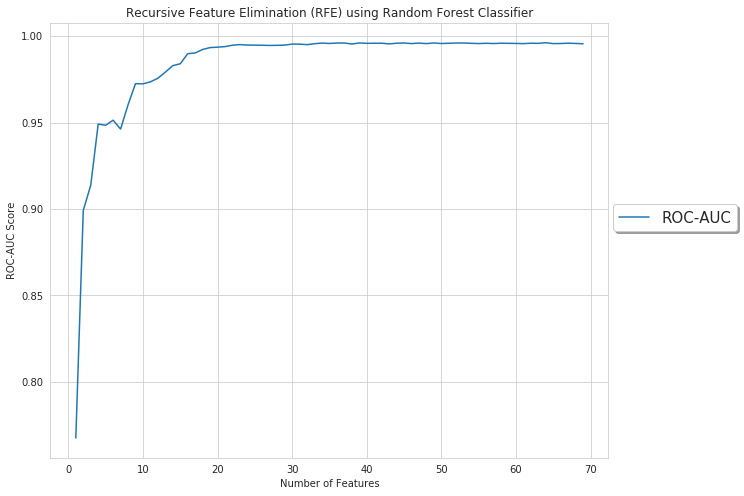

In [64]:
incremental_plot_auc(1,70, title)

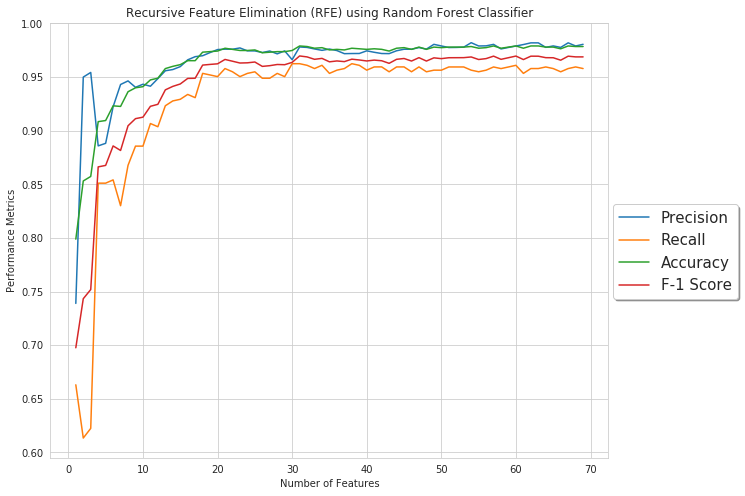

In [65]:
incremental_plot(1,70, title)


In [66]:
#best RFE(Gradient BoostingClassifier) features
clear_metrics()
for index in range(1, 70):
    sel = RFE(GradientBoostingClassifier(n_estimators=100, random_state=0), n_features_to_select = index)
    sel.fit(X_train,y_train)
    X_optimal_gradient = sel.transform(X_validate)
    print(X_optimal_gradient.shape)
    print('Selected Feature: ', index)
    run_randomForest(X_optimal_gradient,y_validate, index)

(1900, 1)
Selected Feature:  1
Classification Report for Random Forest:    1
Accuracy: 0.7736   (+/- 0.0565)
Precision: 0.6222   (+/- 0.0565)
Recall: 0.9052   (+/- 0.0565)
F-1 Score: 0.7372   (+/- 0.0565)
ROC-AUC: 0.8040   (+/- 0.0565)
(1900, 2)
Selected Feature:  2
Classification Report for Random Forest:    2
Accuracy: 0.8531   (+/- 0.0433)
Precision: 0.9500   (+/- 0.0433)
Recall: 0.6135   (+/- 0.0433)
F-1 Score: 0.7434   (+/- 0.0433)
ROC-AUC: 0.8992   (+/- 0.0433)
(1900, 3)
Selected Feature:  3
Classification Report for Random Forest:    3
Accuracy: 0.8573   (+/- 0.0456)
Precision: 0.9543   (+/- 0.0456)
Recall: 0.6225   (+/- 0.0456)
F-1 Score: 0.7519   (+/- 0.0456)
ROC-AUC: 0.9138   (+/- 0.0456)
(1900, 4)
Selected Feature:  4
Classification Report for Random Forest:    4
Accuracy: 0.9084   (+/- 0.0252)
Precision: 0.8858   (+/- 0.0252)
Recall: 0.8511   (+/- 0.0252)
F-1 Score: 0.8662   (+/- 0.0252)
ROC-AUC: 0.9491   (+/- 0.0252)
(1900, 5)
Selected Feature:  5
Classification Report for

(1900, 36)
Selected Feature:  36
Classification Report for Random Forest:    36
Accuracy: 0.9753   (+/- 0.0253)
Precision: 0.9716   (+/- 0.0253)
Recall: 0.9579   (+/- 0.0253)
F-1 Score: 0.9643   (+/- 0.0253)
ROC-AUC: 0.9957   (+/- 0.0253)
(1900, 37)
Selected Feature:  37
Classification Report for Random Forest:    37
Accuracy: 0.9753   (+/- 0.0297)
Precision: 0.9688   (+/- 0.0297)
Recall: 0.9610   (+/- 0.0297)
F-1 Score: 0.9644   (+/- 0.0297)
ROC-AUC: 0.9957   (+/- 0.0297)
(1900, 38)
Selected Feature:  38
Classification Report for Random Forest:    38
Accuracy: 0.9758   (+/- 0.0262)
Precision: 0.9716   (+/- 0.0262)
Recall: 0.9595   (+/- 0.0262)
F-1 Score: 0.9650   (+/- 0.0262)
ROC-AUC: 0.9957   (+/- 0.0262)
(1900, 39)
Selected Feature:  39
Classification Report for Random Forest:    39
Accuracy: 0.9763   (+/- 0.0240)
Precision: 0.9716   (+/- 0.0240)
Recall: 0.9610   (+/- 0.0240)
F-1 Score: 0.9658   (+/- 0.0240)
ROC-AUC: 0.9960   (+/- 0.0240)
(1900, 40)
Selected Feature:  40
Classificat

In [67]:
title = "Recursive Feature Elimination (RFE) using Gradient Boosting Classifier"
results_to_csv(title)

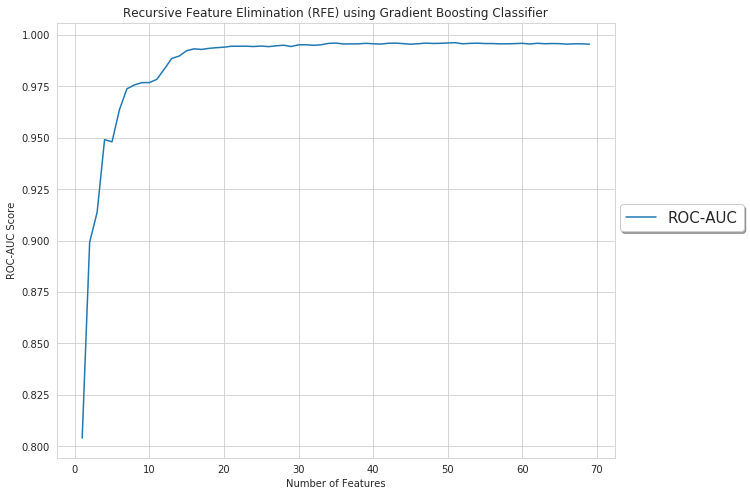

In [68]:
incremental_plot_auc(1,70, title)

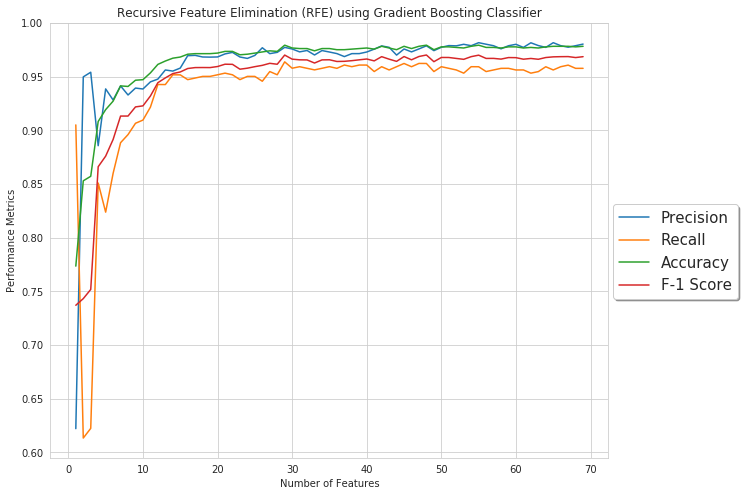

In [69]:
incremental_plot(1,70, title)


## Correlation 

In [141]:
grouped_correlated(to_dataframe(X_train_mutual_info)).shape

# Classifiers Evaluation

## For All Features

In [70]:
%%time
run_randomForest(X, y)

Classification Report for Random Forest:    0
Accuracy: 0.9871   (+/- 0.0101)
Precision: 0.9887   (+/- 0.0101)
Recall: 0.9722   (+/- 0.0101)
F-1 Score: 0.9804   (+/- 0.0101)
ROC-AUC: 0.9984   (+/- 0.0101)
CPU times: user 65.2 ms, sys: 33 ms, total: 98.3 ms
Wall time: 4.33 s


## Recursive Feature Elimination (RFE) using Gradient Boosting Classifier and Random Forest Classifier

In [71]:
clear_metrics()

In [12]:
index =29

In [13]:
%%time
sel = RFE(RandomForestClassifier(n_estimators=100, random_state=0, 
                    n_jobs=-1), n_features_to_select=index)
    
sel.fit(X_train,y_train)
X_optimal_gradient = sel.transform(X)
print(X_optimal_gradient.shape)

(3799, 29)
CPU times: user 10.9 s, sys: 1.03 s, total: 11.9 s
Wall time: 14.9 s


In [14]:
%%time
#print('Selected Feature: ', index)
run_randomForest(X_optimal_gradient,y, index)

Classification Report for Random Forest:    29
Accuracy: 0.9810   (+/- 0.0133)
Precision: 0.9854   (+/- 0.0133)
Recall: 0.9571   (+/- 0.0133)
F-1 Score: 0.9709   (+/- 0.0133)
ROC-AUC: 0.9980   (+/- 0.0133)
CPU times: user 78.9 ms, sys: 37.1 ms, total: 116 ms
Wall time: 4.02 s


In [15]:
X_grouped = grouped_correlated(to_dataframe(X_optimal_gradient))

(3799, 29)
(3799, 25)


In [16]:
%%time
#print('Selected Feature: ', X_grouped.shape[1])
run_randomForest(X_grouped,y, index)

Classification Report for Random Forest:    29
Accuracy: 0.9813   (+/- 0.0148)
Precision: 0.9816   (+/- 0.0148)
Recall: 0.9619   (+/- 0.0148)
F-1 Score: 0.9715   (+/- 0.0148)
ROC-AUC: 0.9979   (+/- 0.0148)
CPU times: user 81.6 ms, sys: 16.9 ms, total: 98.5 ms
Wall time: 2.79 s


In [249]:
title = "Classifier: Recursive Feature Elimination (RFE) using Random Forest Classifier"
results_to_csv(title)

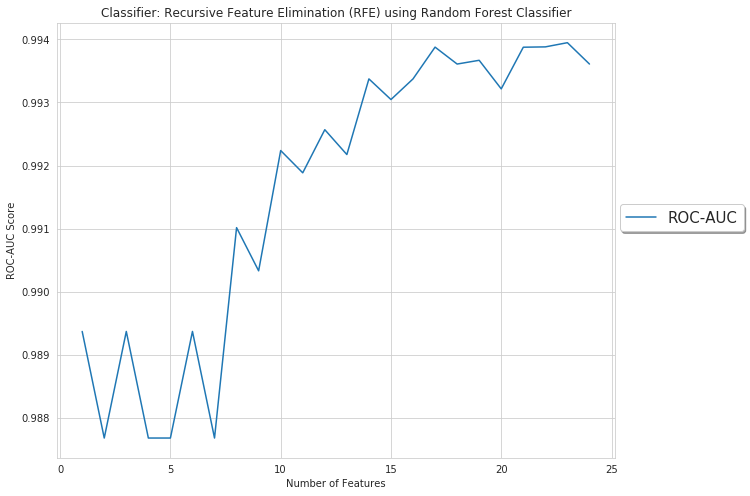

In [253]:
incremental_plot_auc(1,25, title)

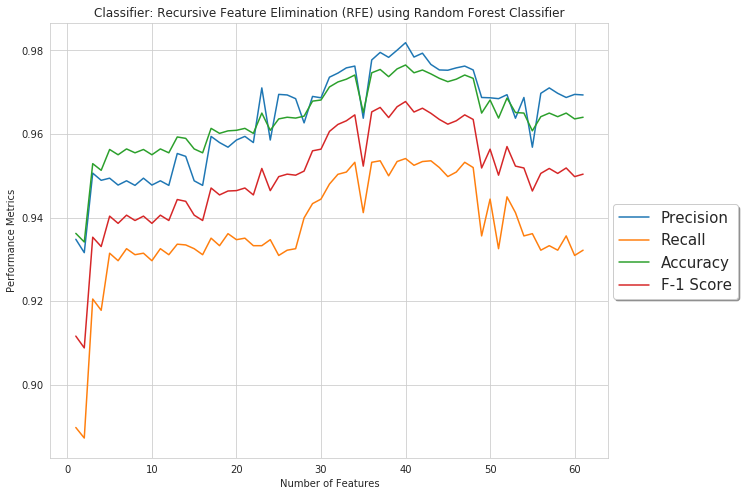

In [550]:
incremental_plot(1,62, title)


In [17]:
selected_rfe_features = pd.DataFrame({'Feature':list(X.columns),
                                      'Ranking':sel.ranking_})
selected_rfe_features.sort_values(by='Ranking')


,Feature,Ranking
0,transact,1
63,Runtime.getRuntime,1
44,IBinder,1
43,android.os.IBinder,1
41,Runtime.exec,1
...,...,...
55,sendDataMessage,37
58,MessengerService,38
57,Context.bindService,39
51,defineClass,40


In [19]:
with open('top_malgenome.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['Feature','Ranking'])
        writer.writerows(zip(selected_rfe_features.Feature, selected_rfe_features.Ranking))

In [20]:
X.columns[sel.support_]

Index(['transact', 'bindService', 'onServiceConnected', 'ServiceConnection',
       'android.os.Binder', 'attachInterface',
       'TelephonyManager.getSubscriberId', 'Ljava.lang.Class.getCanonicalName',
       'Ljava.lang.Class.getField',
       'Landroid.content.Context.unregisterReceiver',
       'Landroid.content.Context.registerReceiver', 'createSubprocess',
       'Ljava.net.URLDecoder', 'TelephonyManager.getDeviceId',
       'abortBroadcast', 'ClassLoader', 'TelephonyManager.getLine1Number',
       'android.telephony.gsm.SmsManager', 'onBind',
       'android.content.pm.Signature', 'PackageInstaller', 'HttpUriRequest',
       'android.telephony.SmsManager', 'Ljava.lang.Class.getResource',
       'Runtime.exec', 'android.os.IBinder', 'IBinder', 'Runtime.getRuntime',
       'Ljavax.crypto.Cipher'],
      dtype='object')

In [21]:
X_top = to_dataframe(X_optimal_gradient)
X_top

(3799, 29)


,1,2,3,4,5,6,7,8,9,10,...,20,21,22,23,24,25,26,27,28,29
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,1,1,1,1,1
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,1,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,1,0,0
5,1,1,1,1,1,1,1,1,0,0,...,1,0,1,0,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3795,0,1,1,1,0,0,0,1,1,1,...,1,0,1,0,0,0,1,1,0,0
3796,1,1,1,1,1,1,0,1,1,1,...,0,0,1,0,1,0,1,1,0,1
3797,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3798,1,1,1,1,1,1,0,1,1,1,...,1,0,1,1,1,1,1,1,1,1


## Feature Importance (Extra Trees and Random Forest Classifier

In [169]:
clear_metrics()

In [170]:
index = 20

In [171]:
top_api_indexes = feat_importances.nlargest(index).index
X_top_feat_imps = X.loc[:,top_api_indexes ]
print(X_top_feat_imps.shape)

(3799, 20)


In [172]:
%%time
run_randomForest(X_top_feat_imps,y, index)

Classification Report for Random Forest:    20
Accuracy: 0.9808   (+/- 0.0182)
Precision: 0.9777   (+/- 0.0182)
Recall: 0.9643   (+/- 0.0182)
F-1 Score: 0.9707   (+/- 0.0182)
ROC-AUC: 0.9951   (+/- 0.0182)
CPU times: user 59.8 ms, sys: 4.25 ms, total: 64 ms
Wall time: 2.7 s


In [173]:
X_grouped = grouped_correlated(X_top_feat_imps)

(3799, 16)


In [174]:
%%time
run_randomForest(X_grouped,y, index)

Classification Report for Random Forest:    20
Accuracy: 0.9792   (+/- 0.0207)
Precision: 0.9752   (+/- 0.0207)
Recall: 0.9619   (+/- 0.0207)
F-1 Score: 0.9684   (+/- 0.0207)
ROC-AUC: 0.9947   (+/- 0.0207)
CPU times: user 63.2 ms, sys: 884 µs, total: 64.1 ms
Wall time: 2.64 s


In [569]:
clear_metrics()

In [616]:
index = 14

In [617]:
pca = PCA(n_components=index, random_state=0)
pca.fit(X_train)
X_pca_optimal = pca.transform(X)

In [618]:
%%time
run_randomForest(X_pca_optimal,y, index)

Classification Report for Random Forest:    14
Accuracy: 0.9745   (+/- 0.0100)
Precision: 0.9795   (+/- 0.0100)
Recall: 0.9509   (+/- 0.0100)
F-1 Score: 0.9650   (+/- 0.0100)
ROC-AUC: 0.9948   (+/- 0.0100)
CPU times: user 63.3 ms, sys: 4.01 ms, total: 67.3 ms
Wall time: 9.4 s


## Random Forest Classifiers for all APIs

In [130]:
%%time
run_randomForest(X, y)

Classification Report for Random Forest:    0
Accuracy: 0.9808   (+/- 0.0076)
Precision: 0.9862   (+/- 0.0076)
Recall: 0.9617   (+/- 0.0076)
F-1 Score: 0.9738   (+/- 0.0076)
ROC-AUC: 0.9963   (+/- 0.0076)
CPU times: user 30.6 ms, sys: 8 ms, total: 38.6 ms
Wall time: 2.88 s


In [105]:
top_api_indexes = []
top_api_indexes = featureScores.Score.nlargest(40).index
X_top_feat_imps = X_grouped_correlated.iloc[0:,top_api_indexes]

In [106]:
%%time
run_randomForest(X_top_feat_imps, y)

Classification Report for Random Forest:    0
Accuracy: 0.9734   (+/- 0.0072)
Precision: 0.9785   (+/- 0.0072)
Recall: 0.9489   (+/- 0.0072)
F-1 Score: 0.9635   (+/- 0.0072)
ROC-AUC: 0.9946   (+/- 0.0072)
CPU times: user 42.6 ms, sys: 3.81 ms, total: 46.4 ms
Wall time: 2.42 s
